# Training in Brax

Once an environment is created in brax, we can quickly train it using brax's built-in training algorithms. Let's try it out!

In [2]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import display, HTML, clear_output

import brax

import flax
from brax import envs
from brax import math
from brax.io import model
from brax.io import json
from brax.io import html
from hct import train as ppo
from brax.training.agents.sac import train as sac
from absl import logging

import getpass
import socket




In [77]:
import numpy as np
from scipy.spatial.transform import Rotation

def shortest_rotation_distance(rotation1, rotation2):
    # Convert rotations to quaternions
    quaternion1 = Rotation.from_euler('xyz', rotation1, degrees=True).as_quat()
    quaternion2 = Rotation.from_euler('xyz', rotation2, degrees=True).as_quat()

    # Calculate the quaternion difference
    quaternion_diff = quaternion2 * np.conjugate(quaternion1)

    # Convert quaternion difference to angle-axis representation
    v = Rotation.from_quat(quaternion_diff).as_rotvec()

    angle_diff = np.linalg.norm(v)
    axis_diff = v/angle_diff
    # Calculate the shortest distance
    shortest_distance = np.linalg.norm(angle_diff * axis_diff)

    return shortest_distance

# Example usage
rotation1 = [180, 0, 0]
rotation2 = [15, 60, 0]

shortest_distance = shortest_rotation_distance(rotation1, rotation2)
print("Shortest rotation distance:", shortest_distance)

Shortest rotation distance: 3.1415926535897922


In [69]:
class Test:
    def g_rot_to_quat(self, X):

        X = jp.array([15,15,180])*X

        return math.euler_to_quat(X)
    
    def quat_to_g_rot(self, rot):
        X = math.quat_to_euler(rot)
        return X/(jp.pi*jp.array([15/180,15/180,1]))

t = Test()
x = []
y = []
rng = jax.random.PRNGKey(seed=292)
for i in range(10):
    
    maxval = 0
    rng, rng1 = jax.random.split(rng)
    r1 = jax.random.uniform(rng, shape = (3,), minval = -0.9999, maxval = 0.9999)
    r2 = jax.random.uniform(rng1, shape = (3,), minval = -0.9999, maxval = 0.9999)

    q1 = t.g_rot_to_quat(r1)
    q2 = t.g_rot_to_quat(r2)

    r01 = t.quat_to_g_rot(q1)

    dq = 2 * math.safe_arccos(jp.abs(jp.dot(q1, q2)))
    
    d = math.safe_norm(r1-r2)
    print(d)

1.279897
2.1724396
0.90139073
1.3372623
3.0891523
2.777106
2.2622027
1.6456612
1.6443377
1.2232972


In [82]:
def quat2expmap(quat: jp.ndarray) -> jp.ndarray:
  """Converts a quaternion to an exponential map
  Matlab port to python for evaluation purposes
  https://github.com/asheshjain399/RNNexp/blob/srnn/structural_rnn/CRFProblems/H3.6m/mhmublv/Motion/quat2expmap.m#L1
  Args:
    quat: 4-dim quaternion
  Returns:
    r: 3-dim exponential map
  Raises:
    ValueError if the l2 norm of the quaternion is not close to 1
  """
  # assert jnp.abs(jnp.linalg.norm(quat) - 1) <= 1e-3, 'quat2expmap: input quaternion is not norm 1'

  sinhalftheta = jp.linalg.norm(quat[1:])
  coshalftheta = quat[0]
  r0 = jp.divide(quat[1:], (jp.linalg.norm(quat[1:]) + jp.finfo(jp.float32).eps))
  theta = 2 * jp.arctan2(sinhalftheta, coshalftheta)
  theta = jp.mod(theta + 2 * jp.pi, 2 * jp.pi)
  r = jax.lax.cond(
    theta > jp.pi,
    lambda x: -r0 * (2 * jp.pi - x),
    lambda x: r0 * x,
    theta)
  return r

axis = jp.array([1,0,0])
angle = jp.array(2)

def distance(a, b):
  angle_b = math.safe_norm(b)
  axis_b = b/angle_b

  angle_b_1 = angle_b + 2*jp.pi
  angle_b_2 = angle_b - 2*jp.pi

  b0 = b
  b1 = axis_b*angle_b_1
  b2 = axis_b*angle_b_2

  b = jp.stack([b0, b1, b2])

  d0 = math.safe_norm(a-b0)
  d1 = math.safe_norm(a-b1)
  d2 = math.safe_norm(a-b2)

  d = jp.array([d0, d1, d2])

  return a, b[jp.argmin(d)]

a = quat2expmap(jp.array([0, 0, 1, 0]))
b = quat2expmap(jp.array([0.00873, 0, 0.9996, 0]))
c = quat2expmap(jp.array([0.00873, 0, -0.9996, 0]))
print(b)
print(c)
print(distance(b,c))

[0.        3.1241255 0.       ]
[ 0.        -3.1241255  0.       ]
(Array([0.       , 3.1241255, 0.       ], dtype=float32), Array([-0.     ,  3.15906, -0.     ], dtype=float32))


In [26]:
import numpy as np
from scipy.spatial.transform import Rotation as R
def quaternion_log(q):
    # Compute the magnitude of the vector part
    v_mag = np.linalg.norm(q[1:])
    
    # Compute the rotation angle
    theta = 2 * np.arctan2(v_mag, q[0])

    # Normalize the vector part
    v = q[1:] / (v_mag + 1e-10)
    
    return theta * v

def quaternion_difference(q1, q2):
    # Compute the quaternion product q2 * inverse(q1)
    q = R.from_quat(q2).inv() * R.from_quat(q1)
    
    # Convert to a quaternion [w, x, y, z]
    q = q.as_quat()
    
    # Compute and return the quaternion logarithm
    return quaternion_log(q)

print(quaternion_difference(q,q))

[ 0.          0.         -3.14159265]


In [3]:


print()
'''
print(r*180)
print(r1*180)
print(q)
print(q1)
print((r+r1)*180)'''

2023-06-16 15:11:01.044208: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[  72.558945  107.1158   -161.3935  ] [-107.441055   72.884186   18.606518]
[ -87.30968  -130.34665    26.322641] [  92.69032  -49.65334 -153.67735]
[ 114.86966  -123.040306   28.028397] [ -65.13034   -56.959686 -151.97159 ]
[-145.20552    -2.436347  -20.782658] [-145.20552     -2.4363472  -20.782658 ]
[-91.53495   -72.292145   -0.3630209] [-91.534935   -72.292145    -0.36301473]
[-23.244282  39.661118  36.082275] [-23.244278  39.66111   36.08227 ]
[  74.24526 -175.16936  159.8543 ] [-105.75474    -4.830633  -20.145704]
[150.11015 -49.18725 -64.91929] [150.11015 -49.18725 -64.91929]
[-132.36818   -30.221071   43.161335] [-132.36818   -30.221073   43.16133 ]
[-177.42465   -35.854183  -45.155224] [-177.42465   -35.854183  -45.155224]



'\nprint(r*180)\nprint(r1*180)\nprint(q)\nprint(q1)\nprint((r+r1)*180)'

First let's pick an environment and a backend to train an agent in. 

Recall from the [Brax Basics](https://github.com/google/brax/blob/main/notebooks/basics.ipynb) colab, that the backend specifies which physics engine to use, each with different trade-offs between physical realism and training throughput/speed. The engines generally decrease in physical realism but increase in speed in the following order: `generalized`,  `positional`, then `spring`.


In [3]:
#@title Load Env { run: "auto" }

env_name = 'ant'  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']
backend = 'positional'  # @param ['generalized', 'positional', 'spring']

env = envs.get_environment(env_name=env_name,
                           backend=backend)
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

display(HTML(html.render(env.sys, [state.pipeline_state])))
print(html.render(env.sys, [state.pipeline_state]))

2023-06-16 19:42:16.617588: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


<!DOCTYPE html>
<html>

  <head>
    <title>Brax visualizer</title>
    <link rel="shortcut icon" type="image/x-icon" href="/favicon.ico">
  </head>

  <style>
    body {
      margin: 0;
      padding: 0;
    }

    #brax-viewer {
      height: 480px;
      margin: 0;
      padding: 0;
    }
  </style>
  <script async src="https://unpkg.com/es-module-shims@1.6.3/dist/es-module-shims.js"></script>

  <script type="importmap">
    {
      "imports": {
        "three": "https://unpkg.com/three@0.150.1/build/three.module.js",
        "three/addons/": "https://unpkg.com/three@0.150.1/examples/jsm/",
        "lilgui": "https://cdn.jsdelivr.net/npm/lil-gui@0.18.0/+esm",
        "viewer": "https://cdn.jsdelivr.net/gh/google/brax@v0.9.1/brax/visualizer/js/viewer.js"
      }
    }
  </script>

  <script type="application/javascript">
  var system = {"dt": 0.005, "gravity": [0.0, 0.0, -9.8100004196167], "viscosity": 0.0, "density": 0.0, "link": {"transform": {"pos": [[0.0, 0.0, 0.0], [0.20000000

In [4]:
env = envs.create(env_name=env_name, backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.random.uniform
jit_inference_fn = jax.random.choice

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act = jit_inference_fn(act_rng, a = jp.array([-1,1]), shape=(8,))
  state = jit_env_step(state, act)

display(HTML(html.render(env.sys.replace(dt=env.dt), rollout)))
print(html.render(env.sys.replace(dt=env.dt), rollout))

<!DOCTYPE html>
<html>

  <head>
    <title>Brax visualizer</title>
    <link rel="shortcut icon" type="image/x-icon" href="/favicon.ico">
  </head>

  <style>
    body {
      margin: 0;
      padding: 0;
    }

    #brax-viewer {
      height: 480px;
      margin: 0;
      padding: 0;
    }
  </style>
  <script async src="https://unpkg.com/es-module-shims@1.6.3/dist/es-module-shims.js"></script>

  <script type="importmap">
    {
      "imports": {
        "three": "https://unpkg.com/three@0.150.1/build/three.module.js",
        "three/addons/": "https://unpkg.com/three@0.150.1/examples/jsm/",
        "lilgui": "https://cdn.jsdelivr.net/npm/lil-gui@0.18.0/+esm",
        "viewer": "https://cdn.jsdelivr.net/gh/google/brax@v0.9.1/brax/visualizer/js/viewer.js"
      }
    }
  </script>

  <script type="application/javascript">
  var system = {"dt": 0.05, "gravity": [0.0, 0.0, -9.8100004196167], "viscosity": 0.0, "density": 0.0, "link": {"transform": {"pos": [[0.0, 0.0, 0.0], [0.200000002

In [25]:
a = jp.array([0])
for r in rollout:
    w =r.x.rot[:,0]
    a = jp.concatenate([a,w],axis=0)

print(len(jp.argwhere(a<0)))


2017


# Training

Brax provides out of the box the following training algorithms:

* [Proximal policy optimization](https://github.com/google/brax/blob/main/brax/training/agents/ppo/train.py)
* [Soft actor-critic](https://github.com/google/brax/blob/main/brax/training/agents/sac/train.py)
* [Evolutionary strategy](https://github.com/google/brax/blob/main/brax/training/agents/es/train.py)
* [Analytic policy gradients](https://github.com/google/brax/blob/main/brax/training/agents/apg/train.py)
* [Augmented random search](https://github.com/google/brax/blob/main/brax/training/agents/ars/train.py)

Trainers take as input an environment function and some hyperparameters, and return an inference function to operate the environment.

# Training

Let's train the Ant policy using the `generalized` backend with PPO.

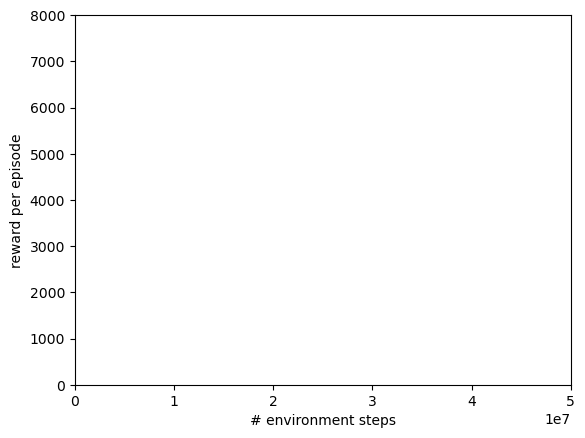

KeyboardInterrupt: 

In [3]:
#@title Training

# We determined some reasonable hyperparameters offline and share them here.
train_fn = {
  'inverted_pendulum': functools.partial(ppo.train, num_timesteps=2_000_000, num_evals=20, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'inverted_double_pendulum': functools.partial(ppo.train, num_timesteps=20_000_000, num_evals=20, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'ant': functools.partial(ppo.train,  num_timesteps=50_000_000, num_evals=10, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=4096, batch_size=2048, seed=1),
  'humanoid': functools.partial(ppo.train,  num_timesteps=50_000_000, num_evals=10, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=10, num_minibatches=32, num_updates_per_batch=8, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=1024, seed=1),
  'reacher': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=4, unroll_length=50, num_minibatches=32, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=256, max_devices_per_host=8, seed=1),
  'humanoidstandup': functools.partial(ppo.train, num_timesteps=100_000_000, num_evals=20, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=15, num_minibatches=32, num_updates_per_batch=8, discounting=0.97, learning_rate=6e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'hopper': functools.partial(sac.train, num_timesteps=6_553_600, num_evals=20, reward_scaling=30, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=512, grad_updates_per_step=64, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192, seed=1),
  'walker2d': functools.partial(sac.train, num_timesteps=7_864_320, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=128, grad_updates_per_step=32, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192, seed=1),
  'halfcheetah': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=20, num_minibatches=32, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4, entropy_cost=0.001, num_envs=2048, batch_size=512, seed=3),
  'pusher': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=30, num_minibatches=16, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4,entropy_cost=1e-2, num_envs=2048, batch_size=512, seed=3),
}[env_name]


max_y = {'ant': 8000, 'halfcheetah': 8000, 'hopper': 2500, 'humanoid': 13000, 'humanoidstandup': 75_000, 'reacher': 5, 'walker2d': 5000, 'pusher': 0}[env_name]
min_y = {'reacher': -100, 'pusher': -150}.get(env_name, 0)

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving and Loading Policies

Brax can save and load trained policies:

In [ ]:
model.save_params('/tmp/params', params)
params = model.load_params('/tmp/params')
inference_fn = make_inference_fn(params)

The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving and Loading Policies

Brax can save and load trained policies:

In [19]:
#@title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name=env_name, backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.random.uniform

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act = jit_inference_fn(act_rng, shape=(8,), minval = -1,maxval=1)
  state = jit_env_step(state, act)

HTML(html.render(env.sys.replace(dt=env.dt), rollout))

In [21]:
env_name = 'ant'  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']
backend = 'positional'  # @param ['generalized', 'positional', 'spring']

env = envs.get_environment(env_name=env_name,
                           backend=backend)
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

HTML(html.render(env.sys, [state.pipeline_state]))

🙌 See you soon!